# Maternal Health Risk: Exploratory Data Analysis
 
### 1. Introduction and Setup
 
This notebook presents a Exploratory Data Analysis (EDA) of the Maternal Health Risk dataset. The primary objective is to understand the underlying patterns, identify key physiological indicators associated with different risk levels, and assess the data's quality for future predictive modeling.

The dataset contains quantitative measurements of pregnant patients, including age, blood pressure, blood sugar, body temperature, and heart rate. The target variable is `RiskLevel`, categorized as 'low risk', 'mid risk', or 'high risk'.


In [54]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from ucimlrepo import fetch_ucirepo

COLOR_PALETTE = 'rocket_r'
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (10, 6)

maternal_health_risk = fetch_ucirepo(id=863)
X = maternal_health_risk.data.features
y = maternal_health_risk.data.targets
df = pd.concat([X, y], axis=1)

print("Dataset loaded successfully!")
df.head()

Dataset loaded successfully!


,Age,SystolicBP,DiastolicBP,BS,BodyTemp,HeartRate,RiskLevel
0,25,130,80,15.0,98.0,86,high risk
1,35,140,90,13.0,98.0,70,high risk
2,29,90,70,8.0,100.0,80,high risk
3,30,140,85,7.0,98.0,70,high risk
4,35,120,60,6.1,98.0,76,low risk


### 2. Data Cleaning and Preprocessing
 
Before analysis, we must ensure the data is clean and reliable. This involves an initial inspection, a thorough investigation of a significant number of duplicate records, and handling any physiological outliers.

#### Initial Data Assessment
 
A quick overview confirms the dataset's structure and types. We have 1014 entries and 7 columns, with no initial missing values. All feature columns are numerical, and the target is an object (string).

In [55]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1014 entries, 0 to 1013
Data columns (total 7 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Age          1014 non-null   int64  
 1   SystolicBP   1014 non-null   int64  
 2   DiastolicBP  1014 non-null   int64  
 3   BS           1014 non-null   float64
 4   BodyTemp     1014 non-null   float64
 5   HeartRate    1014 non-null   int64  
 6   RiskLevel    1014 non-null   object 
dtypes: float64(2), int64(4), object(1)
memory usage: 55.6+ KB


In [56]:
duplicate_count = df.duplicated().sum()
print(f"\nNumber of duplicate rows found: {duplicate_count}")


Number of duplicate rows found: 562


#### Duplicate Record Investigation
 
A preliminary check reveals **562 duplicate rows**, which is more than half the dataset. It's vital to determine if these duplicates are a data entry artifact or represent genuine, repeated measurements before deciding to remove them.

In [57]:
duplicates_df = df[df.duplicated(keep=False)]

print(f"Original DataFrame shape: {df.shape}")
print(f"DataFrame of only duplicated rows, shape: {duplicates_df.shape}")

Original DataFrame shape: (1014, 7)
DataFrame of only duplicated rows, shape: (866, 7)


In [58]:
repetition_counts = duplicates_df.value_counts().sort_values(ascending=False)

print("Top 10 most frequently repeated rows:")
print(repetition_counts.head(10))


Top 10 most frequently repeated rows:
Age  SystolicBP  DiastolicBP  BS    BodyTemp  HeartRate  RiskLevel
19   120         80           7.0   98.0      70         mid risk     27
48   120         80           11.0  98.0      88         high risk    14
31   120         60           6.1   98.0      76         mid risk     13
40   160         100          19.0  98.0      77         high risk    10
55   140         95           19.0  98.0      77         high risk    10
32   140         90           18.0  98.0      88         high risk     9
54   140         100          15.0  98.0      66         high risk     9
42   120         80           7.5   98.0      70         low risk      7
19   120         80           7.0   98.0      70         low risk      7
32   120         90           7.5   98.0      70         low risk      7
Name: count, dtype: int64


In the following scatter plot, the size of each bubble corresponds to how many times that specific patient profile was repeated. The largest bubbles (most frequent duplicates) are concentrated in the 'mid risk' and 'high risk' categories.


In [59]:
duplicates_df = df[df.duplicated(keep=False)]
repetition_counts = duplicates_df.value_counts().sort_values(ascending=False)
repetition_analysis_df = repetition_counts.to_frame('RepetitionCount').reset_index()

fig = px.scatter(
    repetition_analysis_df,
    x="BS",
    y="SystolicBP",
    size="RepetitionCount",
    color="RiskLevel",
    hover_name="RiskLevel",
    hover_data=['Age', 'DiastolicBP', 'BodyTemp', 'HeartRate', 'RepetitionCount'],
    size_max=60,
    color_discrete_map={
        'low risk': '#1f77b4',
        'mid risk': '#ff7f0e',
        'high risk': '#d62728'
    },
    labels={
        "BS": "Blood Sugar (mmol/L)",
        "SystolicBP": "Systolic Blood Pressure (mmHg)",
        "RepetitionCount": "Times Repeated"
    },
    title="Profile of Duplicated Records: Repetition Frequency vs. Clinical Factors"
)

fig.update_layout(
    xaxis_title="Blood Sugar (mmol/L)",
    yaxis_title="Systolic Blood Pressure (mmHg)",
    legend_title_text='Risk Level',
    title_x=0.5
)

fig.show()

 1.  **Biased Distribution:** The distribution of `RiskLevel` in the duplicated data is heavily skewed towards 'mid risk' and 'high risk' categories compared to the unique data. This confirms the duplication was **not a random process**.
2.  **High-Frequency Repeats:** Certain patient profiles, particularly those with high blood sugar and high blood pressure, were repeated many times (one profile was repeated 27 times).

Given that the duplication process was biased and disproportionately amplified specific high-risk profiles, keeping these records would severely skew our analysis and any subsequent machine learning model. Therefore, the correct course of action is to **remove them**.

In [60]:
df.drop_duplicates(inplace=True)
print(f"Duplicates removed. New DataFrame shape: {df.shape}")

Duplicates removed. New DataFrame shape: (452, 7)


#### Handling Data Anomalies
 
A review of the descriptive statistics reveals a minimum `HeartRate` of 7 bpm, which is physiologically impossible for a living person and is clearly a data entry error. We will remove this record to maintain data integrity.


In [61]:
display(df.describe())

df = df[df['HeartRate'] != 7]
print(f"\nOutlier record removed. Final DataFrame shape: {df.shape}")


,Age,SystolicBP,DiastolicBP,BS,BodyTemp,HeartRate
count,452.000000,452.000000,452.000000,452.000000,452.000000,452.000000
mean,29.194690,110.553097,75.418142,8.346173,98.692478,73.949115
std,13.767379,17.872282,13.754578,2.829209,1.410897,8.156973
min,10.000000,70.000000,49.000000,6.000000,98.000000,7.000000
25%,19.000000,90.000000,65.000000,6.900000,98.000000,70.000000
50%,25.000000,120.000000,80.000000,7.500000,98.000000,76.000000
75%,35.000000,120.000000,86.000000,7.900000,98.000000,80.000000
max,70.000000,160.000000,100.000000,19.000000,103.000000,90.000000



Outlier record removed. Final DataFrame shape: (451, 7)


### 3. Exploratory Data Analysis

With a clean dataset, we can now explore the relationships between features and the maternal health risk level.
 
#### Target Variable: Risk Level Distribution

First, let's examine the distribution of our target variable, `RiskLevel`.


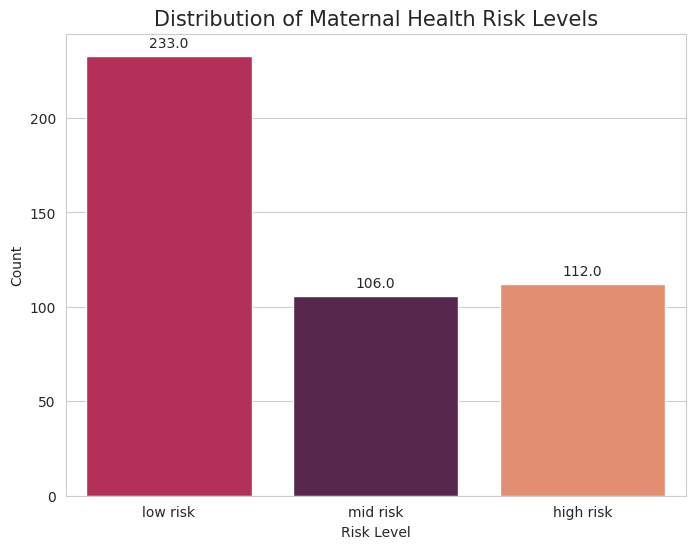

In [62]:
plt.figure(figsize=(8, 6))
risk_order = ['low risk', 'mid risk', 'high risk']

ax = sns.countplot(x='RiskLevel', data=df, order=risk_order, palette=COLOR_PALETTE, hue='RiskLevel', legend=False)

plt.title('Distribution of Maternal Health Risk Levels', fontsize=15)
plt.xlabel('Risk Level')
plt.ylabel('Count')

for p in ax.patches:
    ax.annotate(f'{p.get_height()}', (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center', xytext=(0, 9), textcoords='offset points')

plt.show()

The bar chart shows a significant **class imbalance**. The 'low risk' category (233 instances) is more than double the size of the 'mid risk' (106) and 'high risk' (112) categories. This must be addressed during the modeling phase (e.g., using techniques like SMOTE or class weights) to prevent the model from being biased towards the majority class.

#### Univariate Analysis: Feature Distributions
 
Next, we analyze the distribution of each numerical feature to understand its spread, central tendency, and identify potential outliers.


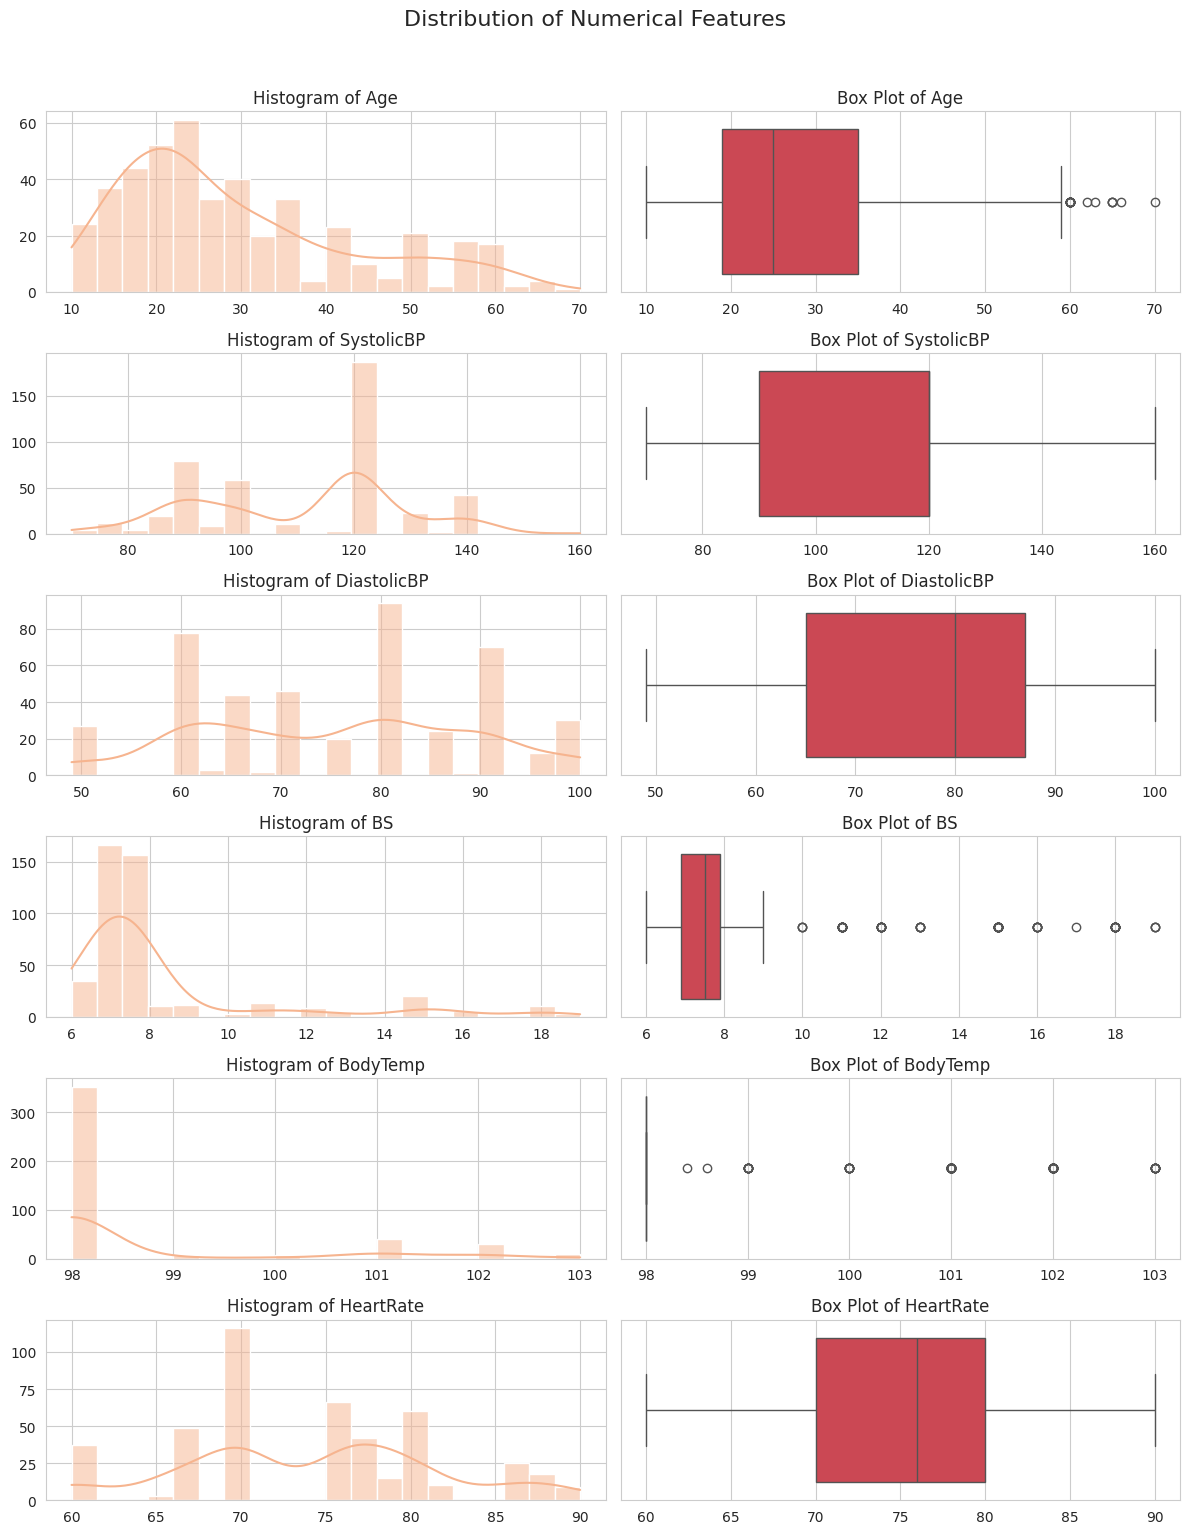

In [63]:
numerical_features = ['Age', 'SystolicBP', 'DiastolicBP', 'BS', 'BodyTemp', 'HeartRate']

fig, axes = plt.subplots(len(numerical_features), 2, figsize=(12, 15))
fig.suptitle('Distribution of Numerical Features', fontsize=16, y=1.02)

for i, col in enumerate(numerical_features):
    sns.histplot(df[col], kde=True, ax=axes[i, 0], bins=20, color=sns.color_palette(COLOR_PALETTE)[0])
    axes[i, 0].set_title(f'Histogram of {col}')
    axes[i, 0].set_xlabel('')
    axes[i, 0].set_ylabel('')

    sns.boxplot(x=df[col], ax=axes[i, 1], color=sns.color_palette(COLOR_PALETTE)[2])
    axes[i, 1].set_title(f'Box Plot of {col}')
    axes[i, 1].set_xlabel('')


plt.tight_layout(rect=[0, 0, 1, 1])
plt.show()


* **Age:** The distribution is right-skewed, indicating the patient base is predominantly young, with fewer older patients who may be at higher risk.
* **Blood Sugar (`BS`):** The presence of numerous high-value outliers is a strong indicator that hyperglycemia is a critical risk factor within this cohort.
* **Blood Pressure (`SystolicBP`, `DiastolicBP`):** Both show wide distributions with several outliers on the higher end, flagging patients with hypertension.
* **Body Temperature (`BodyTemp`):** This feature has a relatively narrow distribution, with a few outliers indicating fevers.

#### Multivariate Analysis: Feature Relationships

Now, we explore how the features relate to each other and to the target variable.

**Correlation Matrix**

The heatmap shows the linear correlation between numerical features.

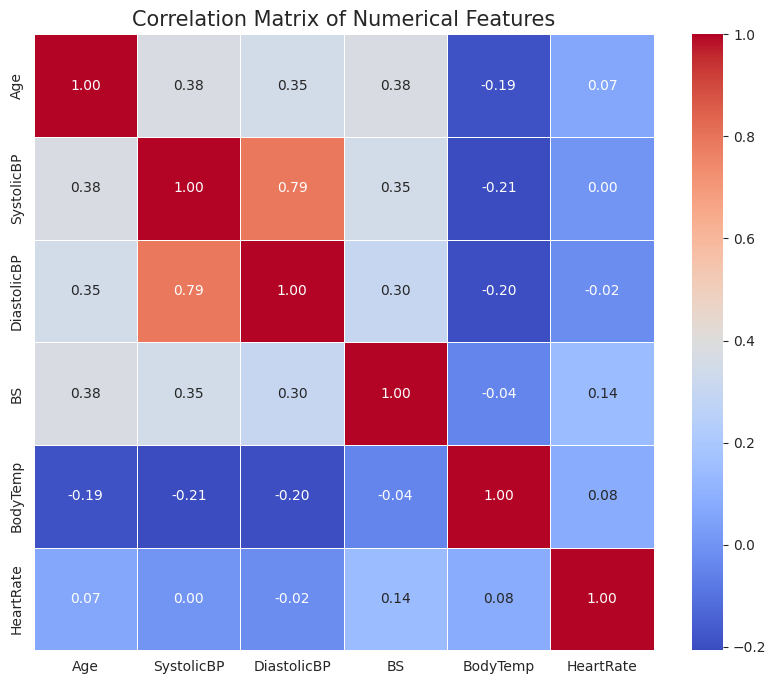

In [64]:
corr_matrix = df[numerical_features].corr()

plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
plt.title('Correlation Matrix of Numerical Features', fontsize=15)
plt.show()

* There is a **strong positive correlation (0.79)** between `SystolicBP` and `DiastolicBP`, which is expected clinically.
* `Age` shows a moderate positive correlation with both `SystolicBP` (0.40) and `BS` (0.47), suggesting that blood pressure and blood sugar tend to increase with age.
* Other correlations are weak, indicating that most features provide unique information.

**Feature Behavior Across Risk Levels**

By visualizing feature distributions for each risk level, we can identify the most powerful predictors.

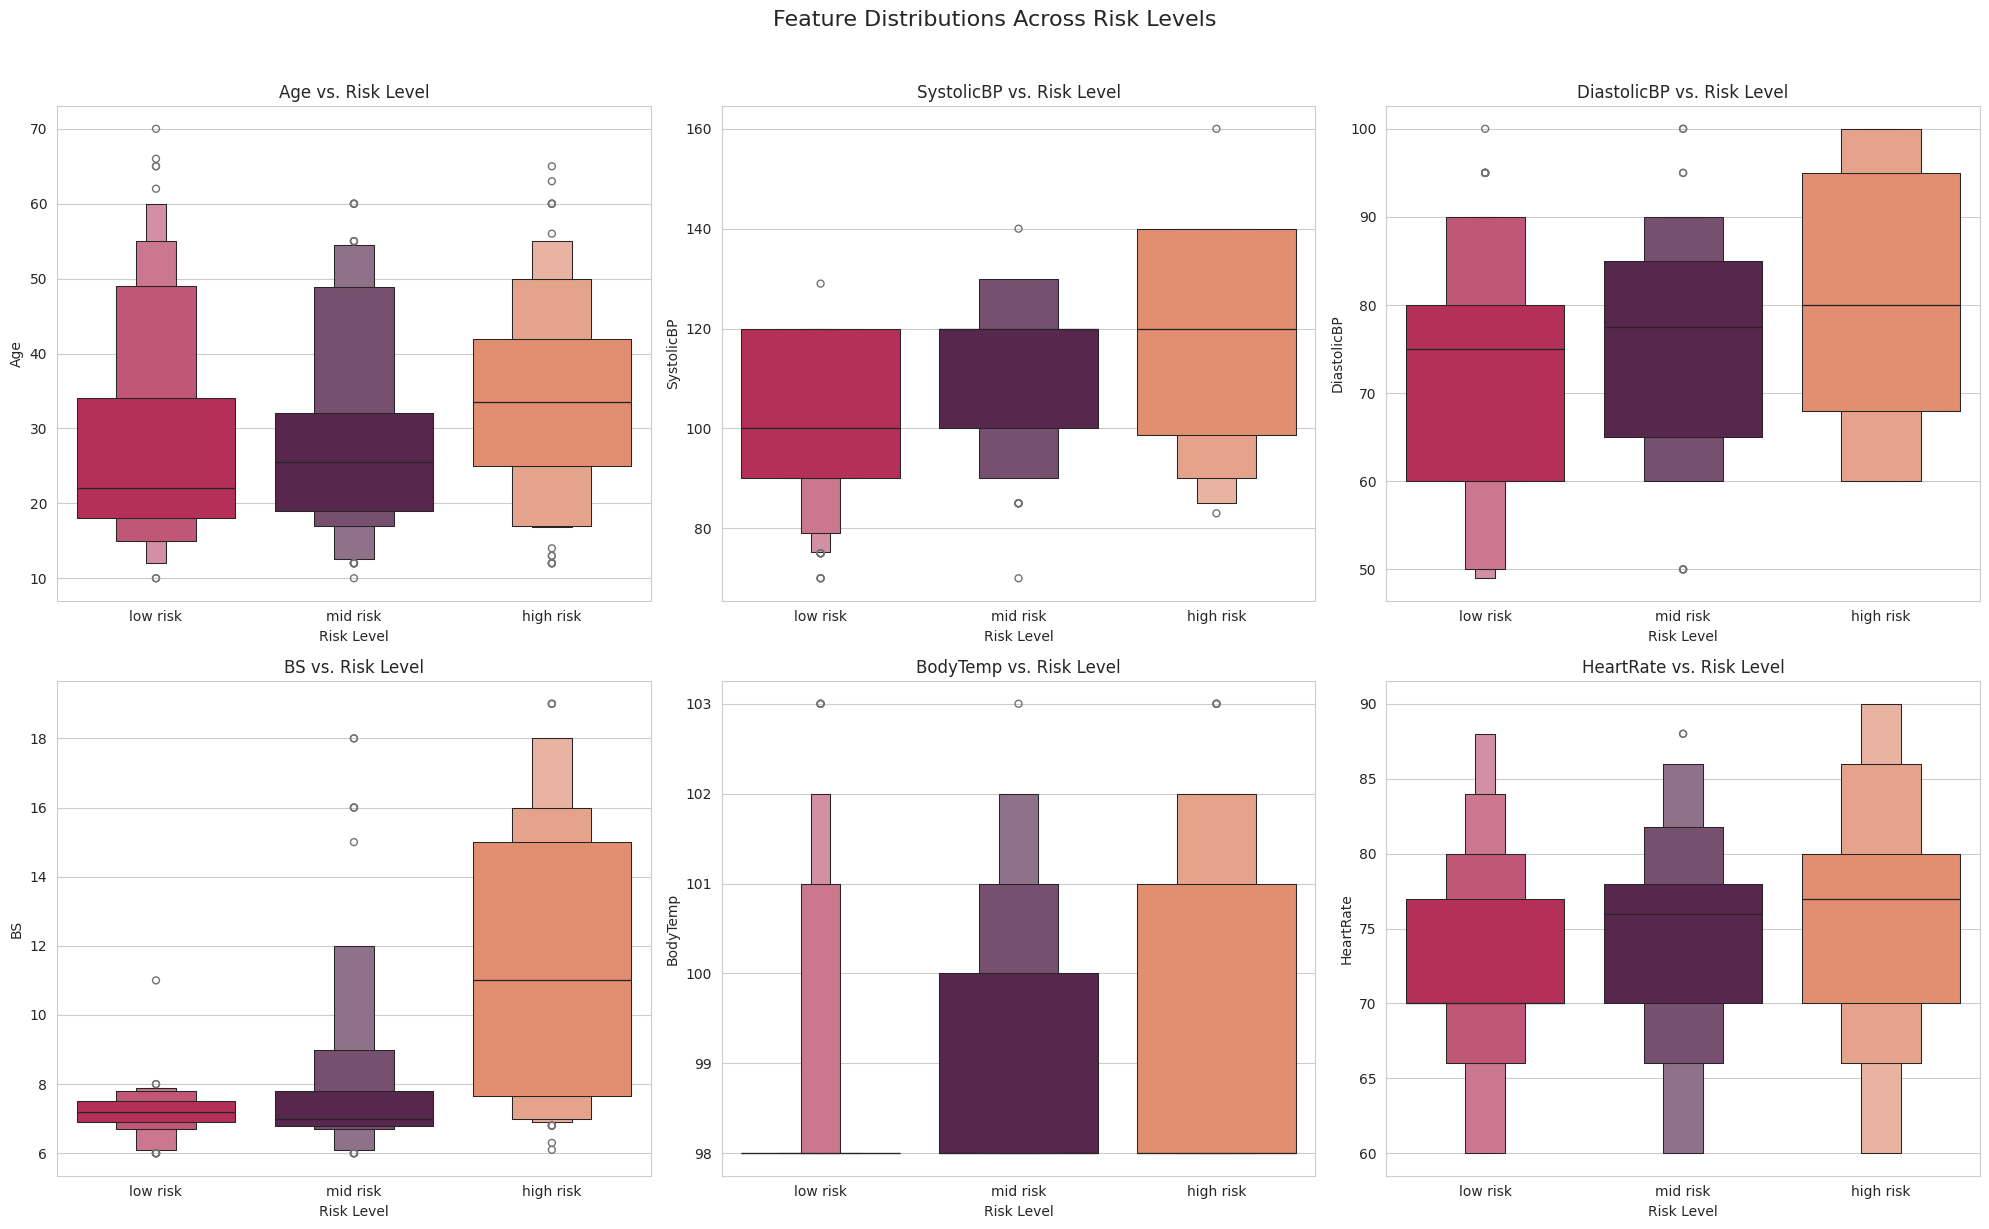

In [65]:
fig, axes = plt.subplots(2, 3, figsize=(20, 12))
fig.suptitle('Feature Distributions Across Risk Levels', fontsize=16, y=1.02)
risk_order = ['low risk', 'mid risk', 'high risk']

for i, col in enumerate(numerical_features):
    row, col_idx = divmod(i, 3)
    sns.boxenplot(x='RiskLevel', y=col, data=df, order=risk_order,
                  ax=axes[row, col_idx], palette=COLOR_PALETTE,
                  hue='RiskLevel', legend=False)
    axes[row, col_idx].set_title(f'{col} vs. Risk Level')
    axes[row, col_idx].set_xlabel('Risk Level')
    axes[row, col_idx].set_ylabel(col)

plt.tight_layout(rect=[0, 0, 1, 1])
plt.show()

* **Strongest Indicators:** `BS`, `SystolicBP`, and `Age` are the most decisive factors. The median and interquartile ranges for these features increase sharply and distinctly as the risk level moves from low to high. The clear separation between the groups makes them excellent predictors.
* **Moderate Indicator:** `HeartRate` also shows a positive trend with risk, but with more overlap between the categories.
* **Weakest Indicator:** `BodyTemp` is the least informative feature. Its distribution is nearly identical across all three risk levels, making it a poor predictor on its own.

**Feature Interactions (Pair Plot)**

The pair plot provides a final confirmation of our findings by visualizing the interactions between features.


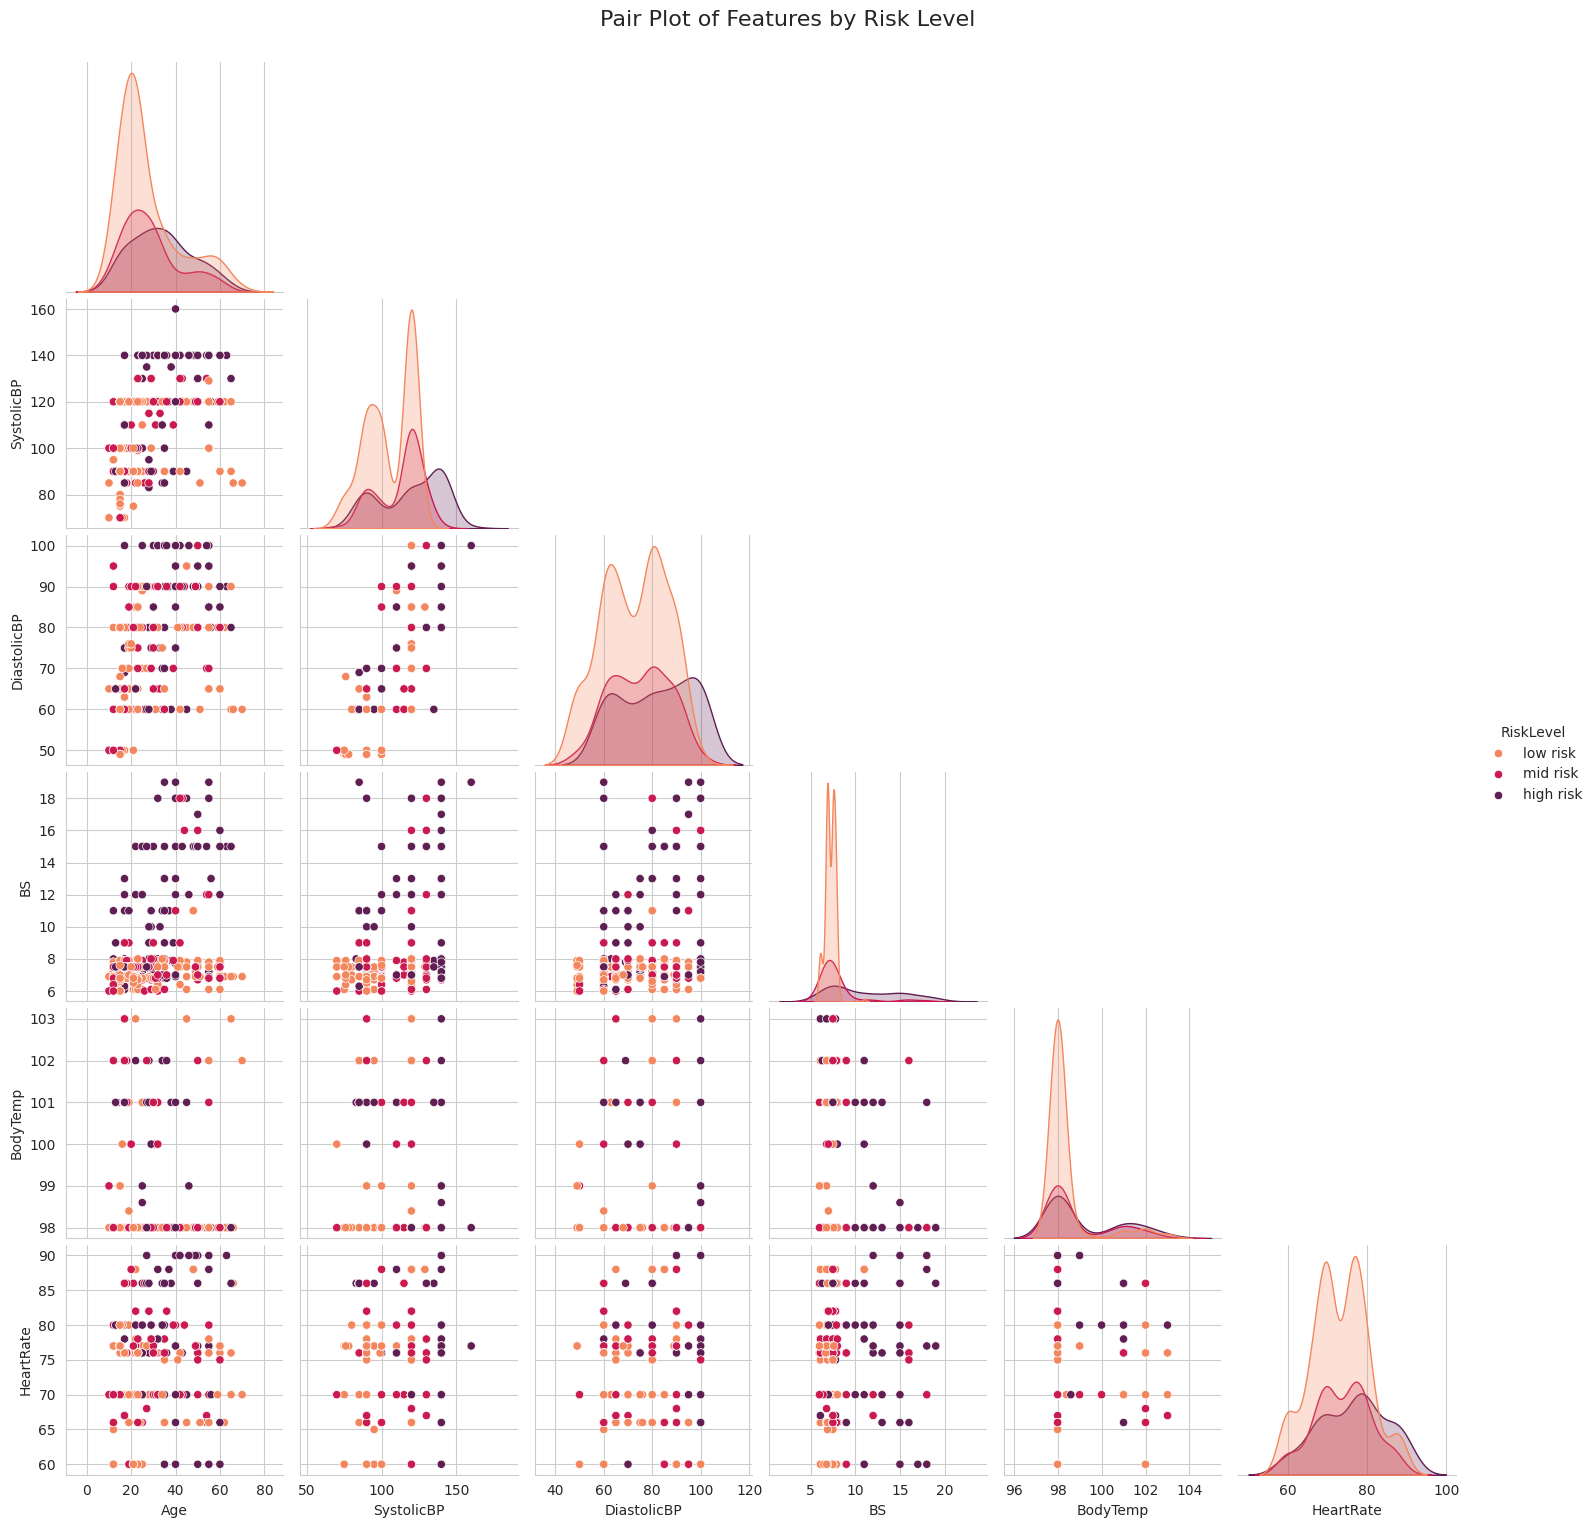

In [66]:
g = sns.pairplot(df, hue='RiskLevel', hue_order=risk_order, palette=COLOR_PALETTE, corner=True)
g.figure.suptitle('Pair Plot of Features by Risk Level', y=1.02, fontsize=16)
plt.show()

The scatter plots confirm that combinations of features provide strong separation between the classes. For example, the plot of `SystolicBP` vs. `BS` shows a distinct cluster of 'high risk' patients in the top-right corner (high blood pressure *and* high blood sugar), well-separated from the 'low risk' group. This reinforces that models capable of capturing these interactions will likely perform well.

### 4. Summary 

1.  **Data Quality:** The dataset required the removal of biased duplicate records and a physiologically impossible outlier.
2.  **Class Imbalance:** The target variable is imbalanced, with 'low risk' being the dominant class. This must be handled during modeling to ensure the accurate prediction of minority 'high risk' cases.
3.  **Key Risk Factors:** **Blood Sugar (`BS`)**, **Systolic Blood Pressure (`SystolicBP`)**, and **Age** are the most powerful individual predictors of maternal health risk.
4.  **Weak Predictor:** **Body Temperature (`BodyTemp`)** shows almost no relationship with the risk level and has limited predictive value.